<a href="https://colab.research.google.com/github/Tanmoy-94/gdp-dashboard/blob/main/Route%20Optimsation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pulp
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

# Define the supply nodes (waste collection points) and their waste generation (supply)
supply_nodes = ["S1", "S2", "S3"]
supply = {"S1": 50, "S2": 60, "S3": 75}  # Waste generated at each collection point

# Define the demand nodes (waste disposal facilities) and their capacities (demand)
demand_nodes = ["D1", "D2", "D3"]
demand = {"D1": 80, "D2": 50, "D3": 55}  # Capacity of each disposal site

# Define transportation costs (distance or cost per unit waste)
costs = {
    ("S1", "D1"): 4, ("S1", "D2"): 6, ("S1", "D3"): 9,
    ("S2", "D1"): 5, ("S2", "D2"): 4, ("S2", "D3"): 7,
    ("S3", "D1"): 6, ("S3", "D2"): 3, ("S3", "D3"): 4,
}

# Define the Linear Programming problem
model = LpProblem("Waste_Transportation_Optimization", LpMinimize)

# Define the decision variables (x_ij: waste transported from S_i to D_j)
x = {(i, j): LpVariable(f"x_{i}_{j}", lowBound=0) for i in supply_nodes for j in demand_nodes}

# Objective function: Minimize total transportation cost
model += lpSum(costs[i, j] * x[i, j] for i in supply_nodes for j in demand_nodes)

# Supply constraints: Total waste sent from a collection point should equal its supply
for i in supply_nodes:
    model += lpSum(x[i, j] for j in demand_nodes) == supply[i]

# Demand constraints: Total waste received at a disposal facility should match its demand
for j in demand_nodes:
    model += lpSum(x[i, j] for i in supply_nodes) == demand[j]

# Solve the model
model.solve()

# Display the results
print("\nOptimal Waste Transportation Plan:")
for i, j in x:
    if x[i, j].varValue > 0:
        print(f"Send {x[i, j].varValue} units from {i} to {j}")

print(f"\nMinimum Total Transportation Cost: {model.objective.value()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 34.4 MB/s eta 0:00:00

Optimal Waste Transportation Plan:
Send 50.0 units from S1 to D1
Send 30.0 units from S2 to D1
Send 30.0 units from S2 to D2
Send 20.0 units from S3 to D2
Send 55.0 units from S3 to D3

Minimum Total Transportation Cost: 750.0


In [4]:
!pip install ortools
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np

# Waste demand at each node (index 0 is depot with 0 demand)
waste_demand = [0, 10, 15, 20, 25, 10, 5]

# Truck capacity
vehicle_capacity = 50

# Number of trucks
num_vehicles = 2

# Depot (disposal facility)
depot_index = 0

# Distance matrix (7 nodes: 1 depot + 6 collection points)
distance_matrix = [
    [0, 9, 14, 23, 30, 18, 20],
    [9, 0, 5, 15, 25, 10, 12],
    [14, 5, 0, 12, 20, 10, 8],
    [23, 15, 12, 0, 8, 16, 14],
    [30, 25, 20, 8, 0, 18, 16],
    [18, 10, 10, 16, 18, 0, 6],
    [20, 12, 8, 14, 16, 6, 0],
]

def create_data_model():
    data = {}
    data["distance_matrix"] = distance_matrix
    data["demands"] = waste_demand
    data["vehicle_capacities"] = [vehicle_capacity] * num_vehicles
    data["num_vehicles"] = num_vehicles
    data["depot"] = depot_index
    return data

def print_solution(data, manager, routing, solution):
    total_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"\nRoute for Truck {vehicle_id + 1}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} (load: {route_load}) ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)} (Return to Depot)"
        plan_output += f"\nDistance of the route: {route_distance} units"
        plan_output += f"\nLoad carried: {route_load} units"
        print(plan_output)
        total_distance += route_distance
    print(f"\nTotal distance of all routes: {total_distance} units")

def main():
    # Instantiate the data problem
    data = create_data_model()

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Define cost function (distance)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add capacity constraint
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],
        True,
        "Capacity"
    )

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print the solution
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found!")

if __name__ == "__main__":
    main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0

Route for Truck 1:
 0 (load: 0) -> 3 (load: 20) -> 4 (load: 45) -> 0 (Return to Depot)
Distance of the route: 61 units
Load carried: 45 units

Route for Truck 2:
 0 (load: 0) -> 1 (load: 10) -> 2 (load: 25) -> 6 (load: 30) -> 5 (load: 40) -> 0 (Return to Depot)
Distance of the route: 46 units
Load carried: 40 units

Total distance of all routes: 107 units


In [11]:
!pip install cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ----------------------------------------
# Step 1: Coordinates (Depot + Collection Points)
# ----------------------------------------
locations = {
    0: [12.9716, 77.5946],  # Depot
    1: [12.9611, 77.6387],
    2: [12.9352, 77.6146],
    3: [12.9496, 77.5905],
    4: [12.9581, 77.5820],
    5: [12.9770, 77.5913],
    6: [12.9861, 77.6050],
}

# ----------------------------------------
# Step 2: VRP Data
# ----------------------------------------
waste_demand = [0, 10, 15, 20, 25, 10, 5]
vehicle_capacity = 50
num_vehicles = 2
depot_index = 0

distance_matrix = [
    [0, 9, 14, 23, 30, 18, 20],
    [9, 0, 5, 15, 25, 10, 12],
    [14, 5, 0, 12, 20, 10, 8],
    [23, 15, 12, 0, 8, 16, 14],
    [30, 25, 20, 8, 0, 18, 16],
    [18, 10, 10, 16, 18, 0, 6],
    [20, 12, 8, 14, 16, 6, 0],
]

# ----------------------------------------
# Step 3: OR-Tools Model
# ----------------------------------------
def create_data_model():
    data = {
        "distance_matrix": distance_matrix,
        "demands": waste_demand,
        "vehicle_capacities": [vehicle_capacity] * num_vehicles,
        "num_vehicles": num_vehicles,
        "depot": depot_index
    }
    return data

def get_routes(data, manager, routing, solution):
    routes = []
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# ----------------------------------------
# Step 4: Plot with Cartopy
# ----------------------------------------
def plot_routes_on_map(locations, routes, output_file="waste_routes_cartopy.jpg"):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([77.56, 77.66, 12.92, 13.00], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    colors = ["blue", "green", "purple", "orange"]

    for i, route in enumerate(routes):
        lat_lon = [locations[node] for node in route]
        lats, lons = zip(*lat_lon)
        ax.plot(lons, lats, color=colors[i % len(colors)], marker='o', linewidth=2,
                label=f"Truck {i + 1}", transform=ccrs.Geodetic())

        # Mark points
        for j, (lat, lon) in enumerate(lat_lon):
            label = "Depot" if j == 0 else f"{route[j]}"
            ax.text(lon + 0.002, lat + 0.002, label, fontsize=9, transform=ccrs.PlateCarree())

    ax.legend()
    plt.title("Optimized Solid Waste Truck Routes")
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"🗺 Map saved as {output_file}")

# ----------------------------------------
# Step 5: Main Execution
# ----------------------------------------
def main():
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"], data["depot"])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_index)

    def demand_callback(from_index):
        return data["demands"][manager.IndexToNode(from_index)]

    demand_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_index, 0, data["vehicle_capacities"],
                                            True, "Capacity")

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_params)

    if solution:
        routes = get_routes(data, manager, routing, solution)
        print("✅ VRP Solution Found. Routes:")
        for i, route in enumerate(routes):
            print(f"Truck {i+1}: {route}")
        plot_routes_on_map(locations, routes)
    else:
        print("❌ No solution found.")

if __name__ == "__main__":
    main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 51.5 MB/s eta 0:00:00
✅ VRP Solution Found. Routes:
Truck 1: [0, 3, 4, 0]
Truck 2: [0, 1, 2, 6, 5, 0]


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

🗺 Map saved as waste_routes_cartopy.jpg


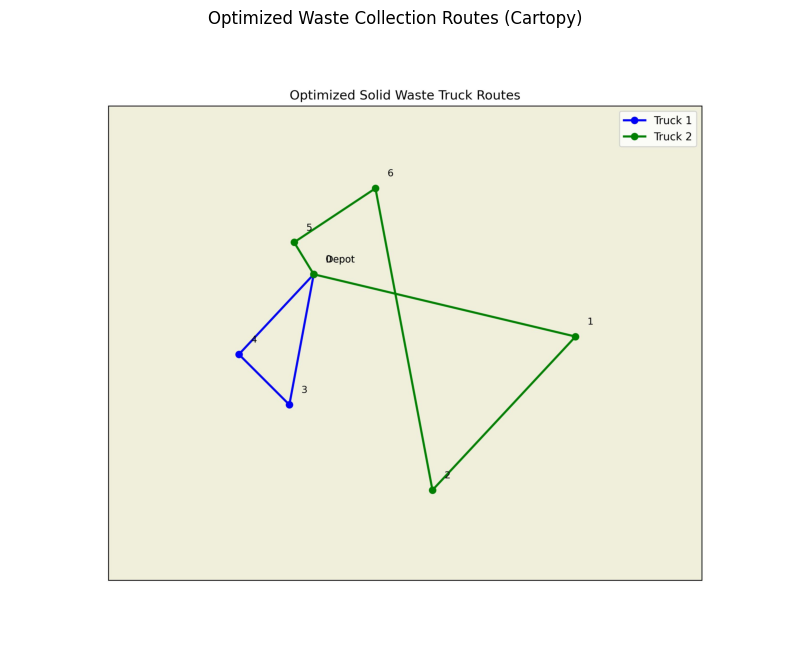

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the generated JPEG map
# Changed the image path to the current directory
image_path = "waste_routes_cartopy.jpg"

# Open the image
img = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Optimized Waste Collection Routes (Cartopy)")
plt.show()